<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial drop duplicates, Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.
5. One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
6. Feature selection: Initial Filter using statistical univariate filter methods. 
7. Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)
8. View Selected Alarms and Discuss with Operations Team
9. With an Alarm, classifed the GT's which had this alarm (allocated on entire start/produced time instead). We then join the alarm mapping with alarm history and join this table to the GT's in production data and perform counts and validate apparent erroneous durations. 
10. Carry out More detailed analysis to gauge size of the prize. Here we hav

In [1]:
import pandas as pd
from helpers import TBM, bcolors, Feature_Selection, Data_Functions

DF = Data_Functions()
TBM = TBM()
p = bcolors()
FS = Feature_Selection()

In [2]:
alarm_join = pd.read_pickle("./pkl/alarms_join.pkl")
df_tbm = pd.read_pickle("./pkl/df_tbm_PAAP_times.pkl")

In [3]:
p.printg(f'Unfiltered Alarm start date: {p.ENDC} {alarm_join.TimeStamp.min()}{p.GREEN}  End Date: {p.ENDC} {alarm_join.TimeStamp.max()}')
p.printg(f'length Alarm: {p.ENDC} {len(alarm_join)}')

Unfiltered Alarm start date:  2022-02-01 00:00:30.6302739  End Date:  2022-05-15 23:59:57.2704392
length Alarm:  1002892


In [4]:
alarm_join_PA = alarm_join[alarm_join.Name.isin(['PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE'])]
#, 'PREASSEMBLY LENGTH NOT CORRECT'
p.printb(f'Number of PA Alarms from {alarm_join_PA.TimeStamp.min()} to {alarm_join_PA.TimeStamp.max()} : {p.ENDC} {len(alarm_join_PA)}')
alarm_join_PA.head()

Number of PA Alarms from 2022-02-01 06:22:29.6168564 to 2022-05-15 23:46:51.9088631 :  4074


,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index
686161,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20838803,2022-02-02 11:04:14.3728587,37,TBM 1,622
686162,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835334,2022-02-02 06:13:42.1412558,37,TBM 1,622
686163,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835442,2022-02-02 06:22:30.7716784,28,TBM 1,622
686164,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835498,2022-02-02 06:25:23.8826590,54,TBM 1,622
686165,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835510,2022-02-02 06:26:46.0468056,37,TBM 1,622


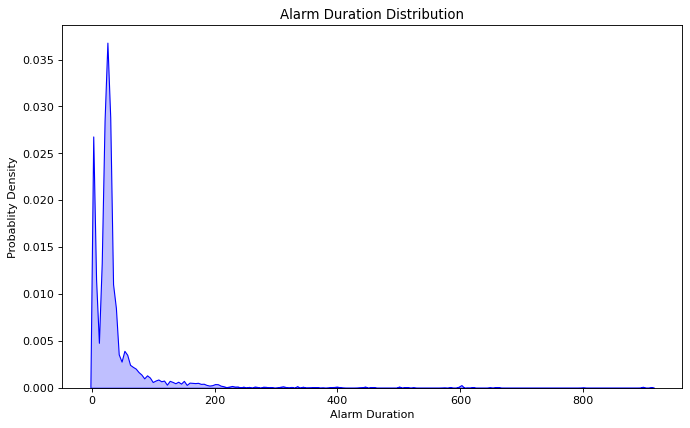

In [5]:
DF.KDE_dist_plotter(alarm_join_PA.Duration, smoothness=.1, title='Alarm Duration Distribution', xlabel='Alarm Duration')

1. This alarm runs for 25 seconds in most cases (If the machine is running in full auto mode). This is the time it takes to be delivered to drum on conveyor and for PAAP.
2. Variations: If the alarm runs for longer than 25 seconds, could be the case that the material is still placed on conveyor, but is not applied on the drum e.g. Maintence people are loading bodyply casette etc. This can cause the alarm duration to be longer. 

In [6]:
p.printg(f'TBM start date: {p.ENDC} {df_tbm.ProducedOn.min()}{p.GREEN}  End Date: {p.ENDC} {df_tbm.ProducedOn.max()}')
p.printg(f'length TBM: {p.ENDC} {len(df_tbm)}')

p.printg(f'PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE Alarm start date: {p.ENDC} {alarm_join_PA.TimeStamp.min()}{p.GREEN}  End Date: {p.ENDC} {alarm_join_PA.TimeStamp.max()}')
p.printg(f'length PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE Alarm: {p.ENDC} {len(alarm_join_PA)}')

TBM start date:  2022-02-01 06:03:43  End Date:  2022-05-16 05:58:30
length TBM:  110584
PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE Alarm start date:  2022-02-01 06:22:29.6168564  End Date:  2022-05-15 23:46:51.9088631
length PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE Alarm:  4074


In [7]:
df_tbm.head(1)

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
0,2022-02-01 06:03:43,TBM 1,1347468,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:03:43,0015600676,GG224517HYPXY,...,5.498,0.0,2.48,11141585,2022-02-01 06:02:06,97,219.620006,85.318002,2022-02-01 06:02:17.681997776,2022-02-01 06:02:12.754997730


In [8]:
alarm_join_PA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 686161 to 691265
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   key               4074 non-null   object
 1   Name              4074 non-null   object
 2   Type              4074 non-null   object
 3   MessageID_x       4074 non-null   int64 
 4   HistoryMessageID  4074 non-null   int64 
 5   TimeStamp         4074 non-null   object
 6   Duration          4074 non-null   int64 
 7   EquipmentID       4074 non-null   object
 8   name_index        4074 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 318.3+ KB


In [9]:
df_tbm['start_time'] = pd.to_datetime(df_tbm['start_time'])
df_tbm['ProducedOn'] = pd.to_datetime(df_tbm['ProducedOn'])
alarm_join_PA['TimeStamp'] = pd.to_datetime(alarm_join_PA['TimeStamp'])

In [10]:
alarm_join_PA.insert(0, 'ID', range(1, 1 + len(alarm_join_PA)))

In [11]:
alarm_join_PA.head()

,ID,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index
686161,1,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20838803,2022-02-02 11:04:14.372858700,37,TBM 1,622
686162,2,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835334,2022-02-02 06:13:42.141255800,37,TBM 1,622
686163,3,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835442,2022-02-02 06:22:30.771678400,28,TBM 1,622
686164,4,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835498,2022-02-02 06:25:23.882659000,54,TBM 1,622
686165,5,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835510,2022-02-02 06:26:46.046805600,37,TBM 1,622


In [12]:
df_allocated_PA = TBM.allocator(df_alarms=alarm_join_PA, df_cycle=df_tbm, df_cycle_end='ProducedOn', df_cycle_start='start_time', column_to_add_to_list='ID')

In [13]:
df_allocated_PA

,Id,list_of_alarms
0,11141585,[]
1,11141586,[]
2,11141588,[]
3,11141590,[]
4,11141591,[]
...,...,...
110579,12467918,[]
110580,12467919,[]
110581,12467920,[]
110582,12468000,[]


In [14]:
masked = FS.mask_empty_lists(df_allocated_PA)

In [15]:
masked_1 = FS.mask_empty_lists_num(masked, 1) # 1 alarm
masked_mult = FS.mask_empty_lists_morethan(masked) # multiple alarms

In [16]:
masked_mult

,Id,list_of_alarms
127,11143412,"[1683, 1719]"
484,11148601,"[135, 136]"
584,11149651,"[147, 148]"
1206,11157152,"[10, 11]"
2028,11166965,"[15, 16, 17]"
...,...,...
100847,12351715,"[3827, 3828]"
104424,12393544,"[2750, 2751]"
107709,12431837,"[2975, 2998]"
108044,12437304,"[2463, 2984]"


In [17]:
masked_1

,Id,list_of_alarms
20,11141738,[2248]
37,11141877,[1643]
38,11141878,[1644]
60,11142156,[1669]
104,11143064,[1666]
...,...,...
110069,12463106,[2733]
110090,12463283,[2739]
110095,12463340,[2740]
110102,12463422,[2636]


In [18]:
masked_4 = FS.mask_empty_lists_num(masked, 4)
masked_4

,Id,list_of_alarms
9272,11248501,"[1585, 1586, 1587, 1588]"
27744,11459515,"[883, 884, 889, 1358]"
32691,11520947,"[655, 657, 658, 659]"
58154,11830526,"[2081, 2082, 2092, 2112]"
70099,11973759,"[3370, 3387, 3389, 4015]"
89559,12222722,"[3858, 3860, 3861, 3862]"


In [20]:
masked_2 = FS.mask_empty_lists_num(masked, 2)
masked_2

,Id,list_of_alarms
127,11143412,"[1683, 1719]"
484,11148601,"[135, 136]"
584,11149651,"[147, 148]"
1206,11157152,"[10, 11]"
3528,11180815,"[1578, 1579]"
...,...,...
100847,12351715,"[3827, 3828]"
104424,12393544,"[2750, 2751]"
107709,12431837,"[2975, 2998]"
108044,12437304,"[2463, 2984]"


In [22]:
df_tbm[df_tbm.Id == 11143412][['ProducedOn', 'RecipeName', 'start_time', 'cycle_time_s', 'PAAP_Finish_time',  'PAAP_Start_time' ]]

,ProducedOn,RecipeName,start_time,cycle_time_s,PAAP_Finish_time,PAAP_Start_time
127,2022-02-01 09:16:43,GG236017HTRNH,2022-02-01 09:10:24,379,2022-02-01 09:16:03.185999990,2022-02-01 09:15:57.429999948


In [23]:
p.printg(f'GT\'s with 1 Allocated Alarms that occur during a GT production: {p.ENDC} {len(masked_1)}')
p.printg(f'GT\'s with more than 1 Allocated Alarms that occur during a GT production: {p.ENDC} {len(masked_mult)}')

GT's with 1 Allocated Alarms that occur during a GT production:  3752
GT's with more than 1 Allocated Alarms that occur during a GT production:  110


In [24]:
PA_alarmed_gts = df_tbm[df_tbm.Id.isin(masked_1.Id.to_list())]

In [25]:
PA_alarmed_gts.head()

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
20,2022-02-01 06:23:57,TBM 1,1347488,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:23:57,0015600698,GG224517HYPXY,...,5.640,0.0,2.405,11141738,2022-02-01 06:21:54,123,224.762004,34.691000,2022-02-01 06:23:22.309000373,2022-02-01 06:23:18.408000350
37,2022-02-01 06:40:40,TBM 1,1347505,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:40:40,0015600716,GG224517HYPXY,...,5.648,0.0,3.458,11141877,2022-02-01 06:39:35,65,83.886999,35.794999,2022-02-01 06:40:04.205000877,2022-02-01 06:40:00.272000789
38,2022-02-01 06:41:52,TBM 1,1347506,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:41:52,0015600718,GG224517HYPXY,...,5.656,0.0,3.457,11141878,2022-02-01 06:40:40,72,110.055001,35.686000,2022-02-01 06:41:16.314000249,2022-02-01 06:41:12.340000272
60,2022-02-01 07:16:54,TBM 1,1347528,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 07:16:54,0015600741,GG224517HYPXY,...,5.756,0.0,3.468,11142156,2022-02-01 07:13:33,201,242.066008,36.101000,2022-02-01 07:16:17.898999572,2022-02-01 07:16:13.960999608
104,2022-02-01 08:46:58,TBM 1,1347572,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 08:46:58,0015600790,GG236017HTRNH,...,5.431,0.0,3.125,11143064,2022-02-01 08:46:08,50,89.573999,36.113000,2022-02-01 08:46:21.887000203,2022-02-01 08:46:13.317000508


In [26]:
masked_1['Alarm_gen_ID'] = [','.join(map(str, l)) for l in masked_1['list_of_alarms']]

In [27]:
masked_1.head()

,Id,list_of_alarms,Alarm_gen_ID
20,11141738,[2248],2248
37,11141877,[1643],1643
38,11141878,[1644],1644
60,11142156,[1669],1669
104,11143064,[1666],1666


In [28]:
key_added = pd.merge(PA_alarmed_gts, masked_1, on='Id')

In [29]:
key_added.head()

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time,list_of_alarms,Alarm_gen_ID
0,2022-02-01 06:23:57,TBM 1,1347488,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:23:57,0015600698,GG224517HYPXY,...,2.405,11141738,2022-02-01 06:21:54,123,224.762004,34.691000,2022-02-01 06:23:22.309000373,2022-02-01 06:23:18.408000350,[2248],2248
1,2022-02-01 06:40:40,TBM 1,1347505,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:40:40,0015600716,GG224517HYPXY,...,3.458,11141877,2022-02-01 06:39:35,65,83.886999,35.794999,2022-02-01 06:40:04.205000877,2022-02-01 06:40:00.272000789,[1643],1643
2,2022-02-01 06:41:52,TBM 1,1347506,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:41:52,0015600718,GG224517HYPXY,...,3.457,11141878,2022-02-01 06:40:40,72,110.055001,35.686000,2022-02-01 06:41:16.314000249,2022-02-01 06:41:12.340000272,[1644],1644
3,2022-02-01 07:16:54,TBM 1,1347528,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 07:16:54,0015600741,GG224517HYPXY,...,3.468,11142156,2022-02-01 07:13:33,201,242.066008,36.101000,2022-02-01 07:16:17.898999572,2022-02-01 07:16:13.960999608,[1669],1669
4,2022-02-01 08:46:58,TBM 1,1347572,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 08:46:58,0015600790,GG236017HTRNH,...,3.125,11143064,2022-02-01 08:46:08,50,89.573999,36.113000,2022-02-01 08:46:21.887000203,2022-02-01 08:46:13.317000508,[1666],1666


In [30]:
alarm_join_PA.rename(columns={"ID": "Alarm_gen_ID"}, inplace=True)
alarm_join_PA.head()

,Alarm_gen_ID,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index
686161,1,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20838803,2022-02-02 11:04:14.372858700,37,TBM 1,622
686162,2,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835334,2022-02-02 06:13:42.141255800,37,TBM 1,622
686163,3,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835442,2022-02-02 06:22:30.771678400,28,TBM 1,622
686164,4,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835498,2022-02-02 06:25:23.882659000,54,TBM 1,622
686165,5,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835510,2022-02-02 06:26:46.046805600,37,TBM 1,622


In [33]:
masked_4

,Id,list_of_alarms
9272,11248501,"[1585, 1586, 1587, 1588]"
27744,11459515,"[883, 884, 889, 1358]"
32691,11520947,"[655, 657, 658, 659]"
58154,11830526,"[2081, 2082, 2092, 2112]"
70099,11973759,"[3370, 3387, 3389, 4015]"
89559,12222722,"[3858, 3860, 3861, 3862]"


In [37]:
df_tbm[df_tbm.Id == 11248501][['ProducedOn', 'RecipeName', 'start_time', 'cycle_time_s', 'PAAP_Finish_time',  'PAAP_Start_time' ]]

,ProducedOn,RecipeName,start_time,cycle_time_s,PAAP_Finish_time,PAAP_Start_time
9272,2022-02-10 07:18:55,GG224517ULAXY,2022-02-10 07:09:38,557,2022-02-10 07:18:14.890999198,2022-02-10 07:17:46.247000098


In [38]:
alarm_join_PA[alarm_join_PA.Alarm_gen_ID.isin([1585, 1586, 1587, 1588])]

,Alarm_gen_ID,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index
687745,1585,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20992561,2022-02-10 07:09:47.203825300,23,TBM 1,622
687746,1586,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20992612,2022-02-10 07:11:35.357238700,4,TBM 1,622
687747,1587,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20992649,2022-02-10 07:16:35.105597700,174,TBM 1,622
687748,1588,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20992666,2022-02-10 07:17:05.572007100,11,TBM 1,622


In [37]:
alarm_join_PA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 686161 to 691265
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Alarm_gen_ID      4074 non-null   int64         
 1   key               4074 non-null   object        
 2   Name              4074 non-null   object        
 3   Type              4074 non-null   object        
 4   MessageID_x       4074 non-null   int64         
 5   HistoryMessageID  4074 non-null   int64         
 6   TimeStamp         4074 non-null   datetime64[ns]
 7   Duration          4074 non-null   int64         
 8   EquipmentID       4074 non-null   object        
 9   name_index        4074 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 350.1+ KB


In [38]:
key_added[['Alarm_gen_ID', 'naive_addition_of_step_times']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3752 entries, 0 to 3751
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alarm_gen_ID                  3752 non-null   object 
 1   naive_addition_of_step_times  3752 non-null   float64
dtypes: float64(1), object(1)
memory usage: 87.9+ KB


In [39]:
key_added['Alarm_gen_ID'] = key_added['Alarm_gen_ID'].astype('int64')

In [40]:
Alarm_data_with_PA_gts = pd.merge(alarm_join_PA,key_added,on='Alarm_gen_ID')

In [41]:
Alarm_data_with_PA_gts.head()

,Alarm_gen_ID,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID_x,name_index,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time,list_of_alarms
0,1,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20838803,2022-02-02 11:04:14.372858700,37,TBM 1,622,...,0.0,2.478,11157450,2022-02-02 11:04:03,149,276.355996,66.549999,2022-02-02 11:05:25.450001359,2022-02-02 11:04:10.632000566,[1]
1,2,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835334,2022-02-02 06:13:42.141255800,37,TBM 1,622,...,0.0,2.675,11154639,2022-02-02 06:13:33,199,270.759992,39.849999,2022-02-02 06:16:12.150000751,2022-02-02 06:13:38.194007099,[2]
2,3,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835442,2022-02-02 06:22:30.771678400,28,TBM 1,622,...,0.0,2.680,11154772,2022-02-02 06:22:23,86,154.556998,39.232000,2022-02-02 06:23:09.768000245,2022-02-02 06:22:27.156000733,[3]
3,4,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835498,2022-02-02 06:25:23.882659000,54,TBM 1,622,...,0.0,2.638,11154774,2022-02-02 06:25:15,72,122.160000,39.194000,2022-02-02 06:25:47.805999637,2022-02-02 06:25:20.230998874,[4]
4,5,95982TBM_1,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",OM,95982,20835510,2022-02-02 06:26:46.046805600,37,TBM 1,622,...,0.0,2.676,11154775,2022-02-02 06:26:27,95,133.328999,39.415000,2022-02-02 06:27:22.584999561,2022-02-02 06:26:43.000999927,[5]


In [42]:
key_added_Alarm_data = Alarm_data_with_PA_gts[[
 'start_time',
 'ProducedOn',
 'Duration',
 'TimeStamp',
 'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP',
 'cycle_time_s',
 'RecipeName',
 'Id',
 'key',
 'Type',
 'Name',
 'EquipmentID_x',
 ]]


In [43]:
key_added_Alarm_data

,start_time,ProducedOn,Duration,TimeStamp,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,cycle_time_s,RecipeName,Id,key,Type,Name,EquipmentID_x
0,2022-02-02 11:04:03,2022-02-02 11:06:32,37,2022-02-02 11:04:14.372858700,74.818001,149,GG225517HYPNW,11157450,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
1,2022-02-02 06:13:33,2022-02-02 06:16:52,37,2022-02-02 06:13:42.141255800,153.955994,199,GG236517HTRNH,11154639,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
2,2022-02-02 06:22:23,2022-02-02 06:23:49,28,2022-02-02 06:22:30.771678400,42.612000,86,GG236517HTRNH,11154772,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3,2022-02-02 06:25:15,2022-02-02 06:26:27,54,2022-02-02 06:25:23.882659000,27.575001,72,GG236517HTRNH,11154774,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
4,2022-02-02 06:26:27,2022-02-02 06:28:02,37,2022-02-02 06:26:46.046805600,39.584000,95,GG236517HTRNH,11154775,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
...,...,...,...,...,...,...,...,...,...,...,...,...
3747,2022-04-02 05:21:47,2022-04-02 05:34:40,11,2022-04-02 05:28:39.698696000,99.612999,773,GG256017QT5NV,11926347,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3748,2022-04-01 18:22:02,2022-04-01 18:22:55,84,2022-04-01 18:22:05.685370300,3.974000,53,GG224517ULAXY,11919533,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3749,2022-04-26 22:40:18,2022-04-26 22:42:35,16,2022-04-26 22:40:20.786218500,3.935000,137,GG224517WPRXV,12216269,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3750,2022-04-02 03:43:52,2022-04-02 03:52:49,54,2022-04-02 03:49:21.889851400,3.969000,537,GG226517ULANV,11925389,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1


1. Find Valid Alarms i.e. Alarm Duration < PAAP Times
2. Error1 i.e. Alarm Duration > PAAP Times 
3. Error2 i.e. Alarm Duration > PAAP Times & Cycle Time

PAAP cannot continue with this alarm - stop m/c

In [45]:
p.printg(f'no. Total Alarms: {p.ENDC} {len(key_added_Alarm_data)}')
valid_alarm = key_added_Alarm_data.loc[(key_added_Alarm_data['Duration'] < key_added_Alarm_data.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.printg(f'no. Valid Alarms: {p.ENDC} {len(valid_alarm)}')
error1_alarm = key_added_Alarm_data.loc[(key_added_Alarm_data['Duration'] > key_added_Alarm_data.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.printg(f'no. Error 1 Alarms: {p.ENDC} {len(error1_alarm)}')
error2_alarm = key_added_Alarm_data.loc[(key_added_Alarm_data['Duration'] > key_added_Alarm_data.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP) & (key_added_Alarm_data['Duration'] > key_added_Alarm_data.cycle_time_s)]
p.printg(f'no. Error 2 Alarms: {p.ENDC} {len(error2_alarm)}')

no. Total Alarms:  3752
no. Valid Alarms:  1218
no. Error 1 Alarms:  2534
no. Error 2 Alarms:  190


Need to confrim the trigger for the PAAP cycle time. If the Trigger is after PA alarm, then Error 2 is not an issue. Will ignore the ones where it is longer than cycle time. 

In [47]:
valid_alarm

,start_time,ProducedOn,Duration,TimeStamp,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,cycle_time_s,RecipeName,Id,key,Type,Name,EquipmentID_x
0,2022-02-02 11:04:03,2022-02-02 11:06:32,37,2022-02-02 11:04:14.372858700,74.818001,149,GG225517HYPNW,11157450,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
1,2022-02-02 06:13:33,2022-02-02 06:16:52,37,2022-02-02 06:13:42.141255800,153.955994,199,GG236517HTRNH,11154639,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
2,2022-02-02 06:22:23,2022-02-02 06:23:49,28,2022-02-02 06:22:30.771678400,42.612000,86,GG236517HTRNH,11154772,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
4,2022-02-02 06:26:27,2022-02-02 06:28:02,37,2022-02-02 06:26:46.046805600,39.584000,95,GG236517HTRNH,11154775,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
5,2022-02-02 06:30:01,2022-02-02 06:33:06,61,2022-02-02 06:30:44.240151800,106.016998,185,GG236517HTRNH,11154812,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
...,...,...,...,...,...,...,...,...,...,...,...,...
3732,2022-05-07 03:45:39,2022-05-07 03:46:42,4,2022-05-07 03:45:47.590631100,23.014999,63,GG226517HTRNH,12343133,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3733,2022-05-02 08:06:35,2022-05-02 08:08:24,2,2022-05-02 08:06:44.873463400,3.983000,109,GG226017QPRXV,12276709,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3741,2022-04-01 19:19:21,2022-04-01 19:20:58,23,2022-04-01 19:19:28.156483900,63.377998,97,GG224517ULAXY,11919967,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3742,2022-04-25 21:12:59,2022-04-25 21:21:15,2,2022-04-25 21:19:32.009836400,7.057000,496,GG216017QPRXV,12201306,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1


In [187]:
key_added_Alarm_data.to_pickle('./pkl/PA_Alarms_joined_with_tbm_data.pkl')